In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
from math import sqrt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn import model_selection


In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
def accumulate_canonical_info(x_arr, y_arr):
    n = 1
    v = y_arr[0]*y_arr[0]
    u = np.array([1*y_arr[0], x_arr[0]*y_arr[0]])
    T = np.array(
        [[1, x_arr[0]],
         [x_arr[0], x_arr[0]*x_arr[0]]]
    )
    for i in range(1, len(x_arr)):
        n+=1
        v+=y_arr[i]*y_arr[i]
        u+=np.array([1*y_arr[i], x_arr[i]*y_arr[i]])
        T+=np.array(
        [[1, x_arr[i]],
         [x_arr[i], x_arr[i]*x_arr[i]]]
        )
    return (n-1, v, u, T)

In [4]:
predicted_func = lambda x, a, b: a*x+b
F = lambda n : np.array([1, x[n]])
rand_points = lambda n, lim: np.random.choice(lim, n, replace=False)
def plot_results(x, y, a, b, variance_est):
    plt.ylim(0, 15)
    plt.xlim(-5, 1000)
    plt.scatter(x, y, color='b')
    plt.plot(x, [predicted_func(x_point, a, b) for x_point in x], color='R', label='predicted', linewidth=3.0)
    plt.plot(x[:], [predicted_func(x_point, a, b)+sqrt(var_est) for x_point, var_est in zip(x, variance_est)], color='c', linewidth=1.0, label='variance_estimation')
    plt.plot(x[:], [predicted_func(x_point, a, b)-sqrt(var_est) for x_point, var_est in zip(x, variance_est)], color='c', linewidth=1.0)
    plt.title('Estimation for timing, a = {a:9.5f}, b = {b:9.5f}'.format(a=a, b=b))
    plt.legend(loc='best')
    plt.show()

In [5]:
def get_results(x, y, plot=True):
    variance = []
    n, v, u, T = accumulate_canonical_info(x, y)
    b, a = [*np.linalg.inv(T).dot(u)]
    variance_est = [
        (
            v-u.transpose().dot(
            np.linalg.inv(T)
            ).dot(u)
        )*(
            F(i).dot(
                np.linalg.inv(T)
            ).dot(
                F(i).transpose()
            )
        )/(n-2)
        for i in range(len(x))
    ]
    if plot:
        plot_results(x,y, a, b, variance_est)
    return a, b

In [6]:
df = pd.read_csv('timing_dataset.csv', sep=';').groupby('Orders').mean()

In [7]:
df.describe()

,Timing
count,57.000000
mean,9.314721
std,4.347756
min,0.775026
25%,5.326419
50%,10.675629
75%,12.577260
max,17.301093


In [8]:
x = df.index
y = np.array(df.Timing)

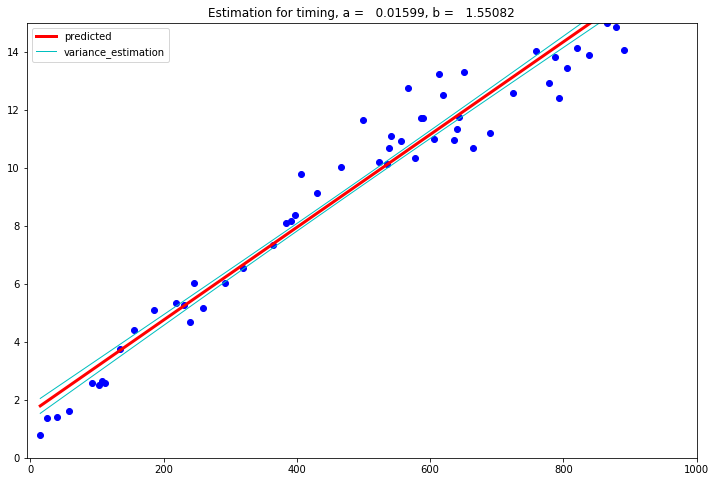

In [9]:
a, b = get_results(x,y)

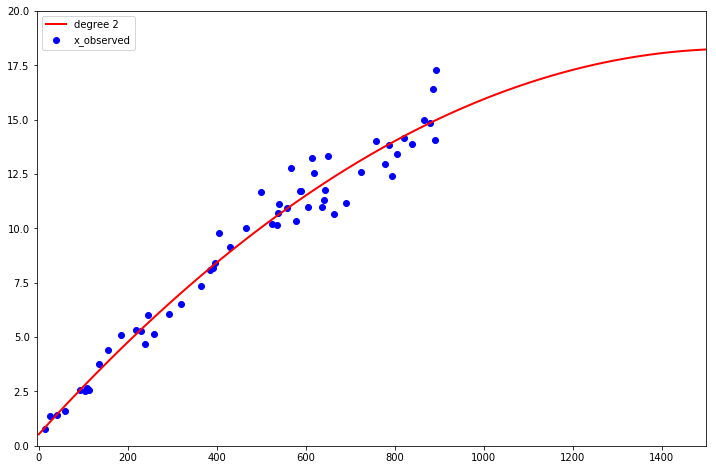

In [10]:
x_plot = np.linspace(0, 1500, 100)[:, np.newaxis]
plt.ylim(0, 20)
plt.xlim(-5, 1500)
model = PolynomialFeatures(2)
pipe = make_pipeline(model, Ridge())
pipe.fit(x[:, np.newaxis], y[:, np.newaxis])
y_plot = pipe.predict(x_plot)
plt.plot(x_plot, y_plot, color='R', linewidth=2,
         label="degree {d}".format(d=2))
plt.scatter(x, y, color='b', label='x_observed')

plt.legend(loc='best')
plt.show()

In [11]:
model = PolynomialFeatures(2)
pipe = make_pipeline(model, Ridge())
scores = []
folded_data = model_selection.KFold(n_splits=10)
for k, (train, test) in enumerate(folded_data.split(x, y)):
    pipe.fit(x[train][:, np.newaxis], y[train][:, np.newaxis])
    y_predicted = pipe.predict(x[test][:, np.newaxis])
    score = mean_squared_error(y[test], y_predicted)
    scores.append(score)
    print('[fold {0}], score: {1:.3f}'.format(k, score))
print('mean = {:.3f}'.format(np.mean(scores)))

[fold 0], score: 0.041
[fold 1], score: 0.195
[fold 2], score: 0.403
[fold 3], score: 0.321
[fold 4], score: 0.645
[fold 5], score: 0.748
[fold 6], score: 1.010
[fold 7], score: 1.545
[fold 8], score: 0.919
[fold 9], score: 3.383
mean = 0.921


In [12]:
scores = []
folded_data = model_selection.KFold(n_splits=10)
for k, (train, test) in enumerate(folded_data.split(x, y)):
    a, b = get_results(x[train], y[train], plot = False)
    func = lambda x, a, b: a*x+b
    y_predicted = [func(x, a, b) for x in x[test]]
    score = mean_squared_error(y[test], y_predicted)
    scores.append(score)
    print('[fold {0}], score: {1:.3f}'.format(k, score))
print('mean = {:.3f}'.format(np.mean(scores)))

[fold 0], score: 1.454
[fold 1], score: 0.260
[fold 2], score: 0.201
[fold 3], score: 0.779
[fold 4], score: 1.304
[fold 5], score: 1.148
[fold 6], score: 1.301
[fold 7], score: 1.418
[fold 8], score: 1.777
[fold 9], score: 1.294
mean = 1.094
